# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Usage" data-toc-modified-id="Usage-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Usage</a></div><div class="lev1 toc-item"><a href="#Extensions" data-toc-modified-id="Extensions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Extensions</a></div><div class="lev1 toc-item"><a href="#Implementation" data-toc-modified-id="Implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation</a></div><div class="lev2 toc-item"><a href="#Syntax-tree-self.spec" data-toc-modified-id="Syntax-tree-self.spec-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Syntax tree <code>self.spec</code></a></div><div class="lev2 toc-item"><a href="#Summary-statistics-summarize()" data-toc-modified-id="Summary-statistics-summarize()-32"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Summary statistics <code>summarize()</code></a></div><div class="lev2 toc-item"><a href="#Plotting-plot()" data-toc-modified-id="Plotting-plot()-33"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Plotting <code>plot()</code></a></div>

In [1]:
import sys
sys.executable

'/Users/Nikhil/Desktop/ccn-benchmarks/venv/bin/python3.7'

In [2]:
from IPython.display import display, set_matplotlib_formats, HTML
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
set_matplotlib_formats('retina')
sns.set(rc={"figure.figsize": (6, 4)})
sns.set_style('ticks')
sns.set_context('notebook', rc={"lines.linewidth": 2.5})

In [3]:
def display_side_by_side(*dfs):
    display(HTML(
        '<div style="display: flex; flex-direction: row; gap: 12px;">' + 
        ''.join(['<div>' + df._repr_html_() + '</div>' for df in dfs]) +
        '</div>'
    ))

# Usage

In [4]:
# experiments('Acq*')
# experiments.Acquisition_ContinuousPartial()

In [5]:
# exp = experiments.Acquisition_ContinuousPartial()
# print(exp.cs_space)
# print(exp.ctx_space)
# print(exp.stimulus('continuous', 0, 7))
# print(exp.stimulus('continuous', 0, 7, vector=True))

In [6]:
import random

class RandomModel:
    """Produces response with probability that changes linearly with each US."""
    def __init__(self, start=0.2, delta=0.1, min_prob=0.1, max_prob=0.9):
        self.prob = start
        self.start = start
        self.delta = delta
        self.min_prob = min_prob
        self.max_prob = max_prob
        
    def reset(self):
        self.prob = start
    
    def act(self, cs, ctx, us):
        if us > 0:
            self.prob = max(min(self.prob + self.delta, self.max_prob), self.min_prob)
            return 1
        if len(cs) > 0:
            return random.choices([1, 0], weights=[self.prob, 1-self.prob])[0]
        return 0

Recovery_LatentInhibition
    correlation: -0.8164965809277264


,group,variable,value
0,control,A,2.2
1,latent inhibition,A,1.6
2,control recovery,A,1.9
3,latent inhibition recovery,A,1.9
,group,variable,value
0,control,A,0.750000
1,latent inhibition,A,0.916667
2,control recovery,A,0.916667
3,latent inhibition recovery,A,0.916667


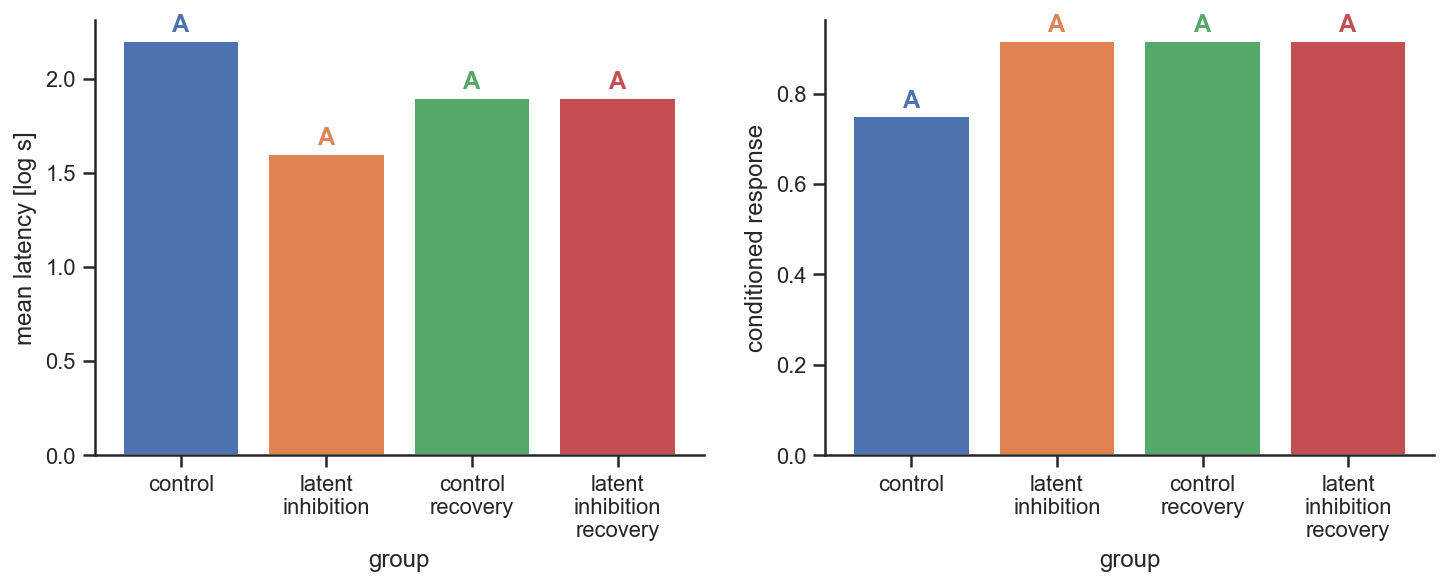

Recovery_Overshadowing
    correlation: 0.832239719563824


,group,variable,value
0,control,A,1.95
1,overshadowing,A,1.05
2,overshadowing recovery,A,1.55
,group,variable,value
0,control,A,1.00
1,overshadowing,A,0.75
2,overshadowing recovery,A,0.75


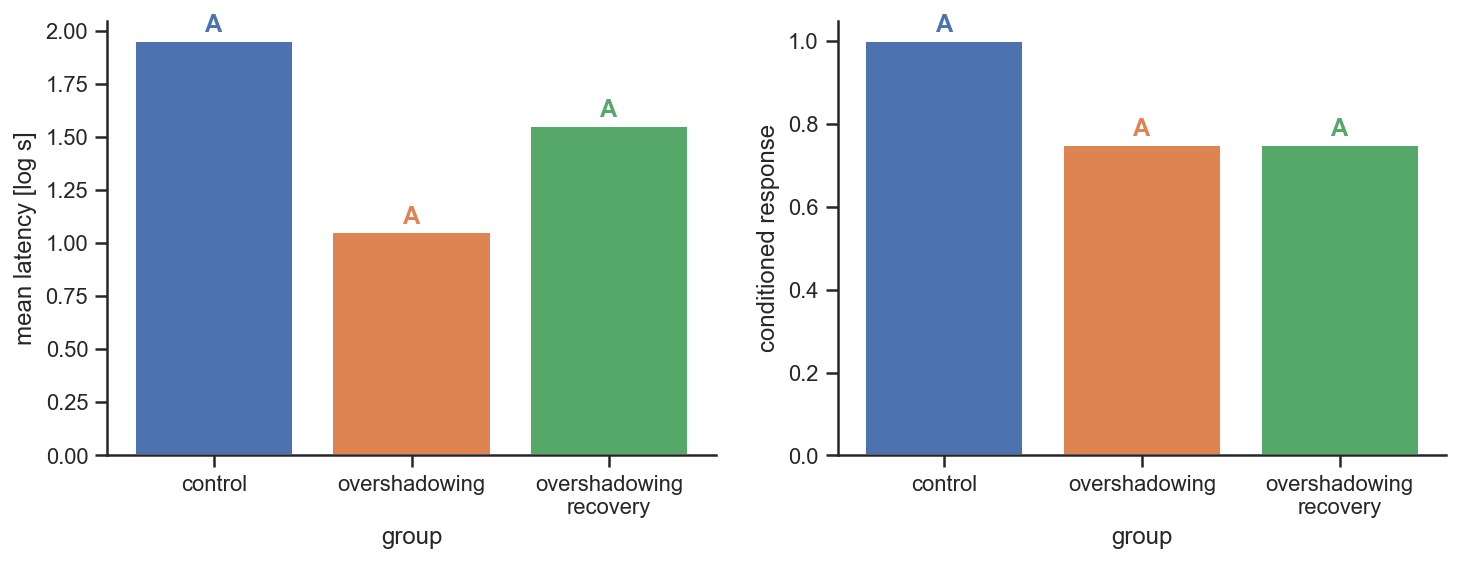

Recovery_ExternalDisinhibition
    correlation: 0.08931185723384957


,group,variable,value
0,main,extinction,0.50
1,main,test 1,0.85
2,main,test 2,0.78
,group,variable,value
0,main,extinction,0.908333
1,main,test 1,1.000000
2,main,test 2,0.777778


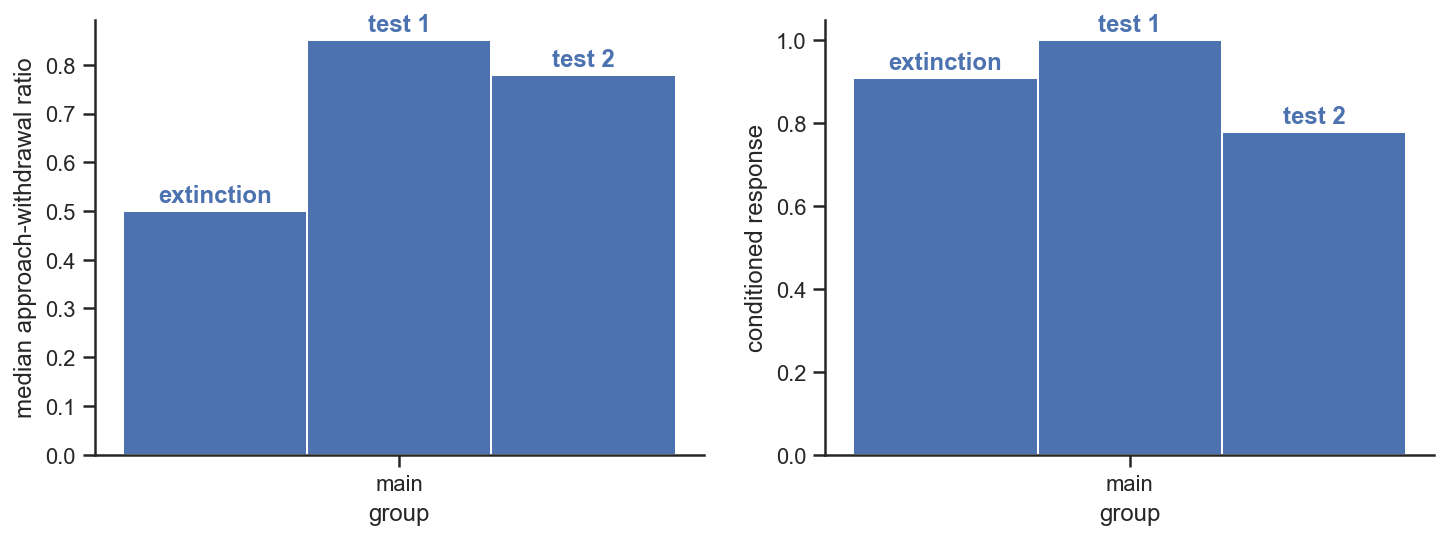

Recovery_Renewal
    correlation: -1.0


,group,variable,value
0,same context,A,27
1,novel context,A,55
,group,variable,value
0,same context,A,0.900
1,novel context,A,0.875


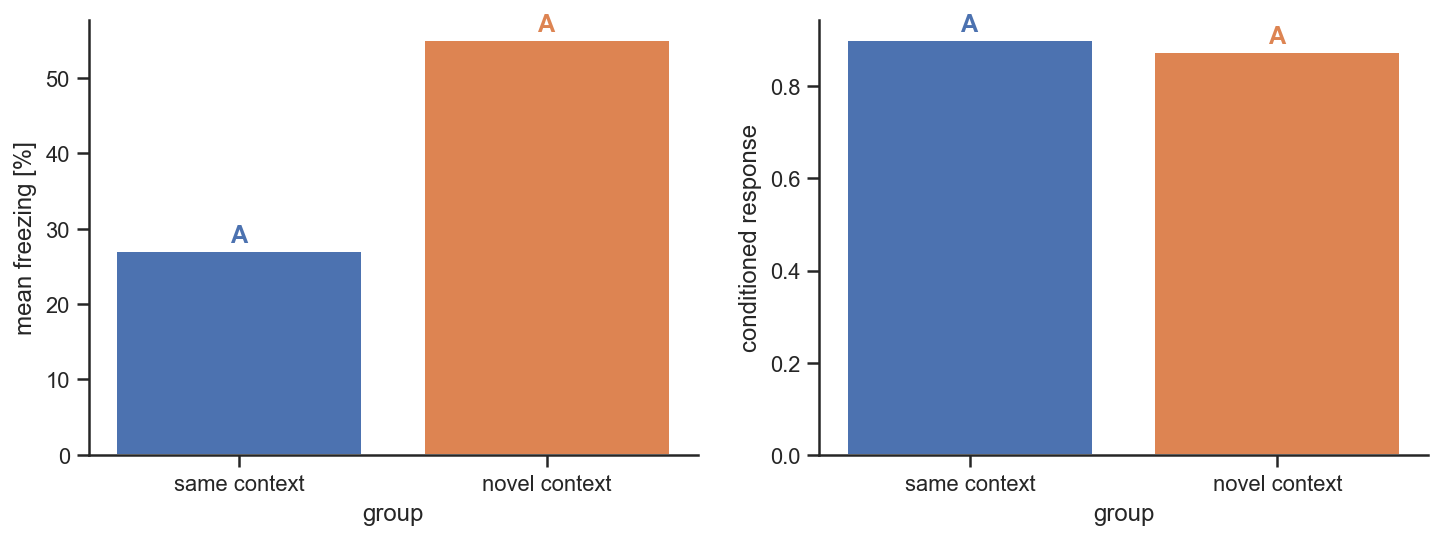

Recovery_Reinstatement
    correlation: nan


,group,variable,value
0,no US,extinction,0.35
1,US,extinction,0.40
2,no US,test 1,0.40
3,US,test 1,0.21
4,no US,test 2,0.40
5,US,test 2,0.36
,group,variable,value
0,no US,extinction,1.0
1,US,extinction,1.0
2,no US,test 1,1.0


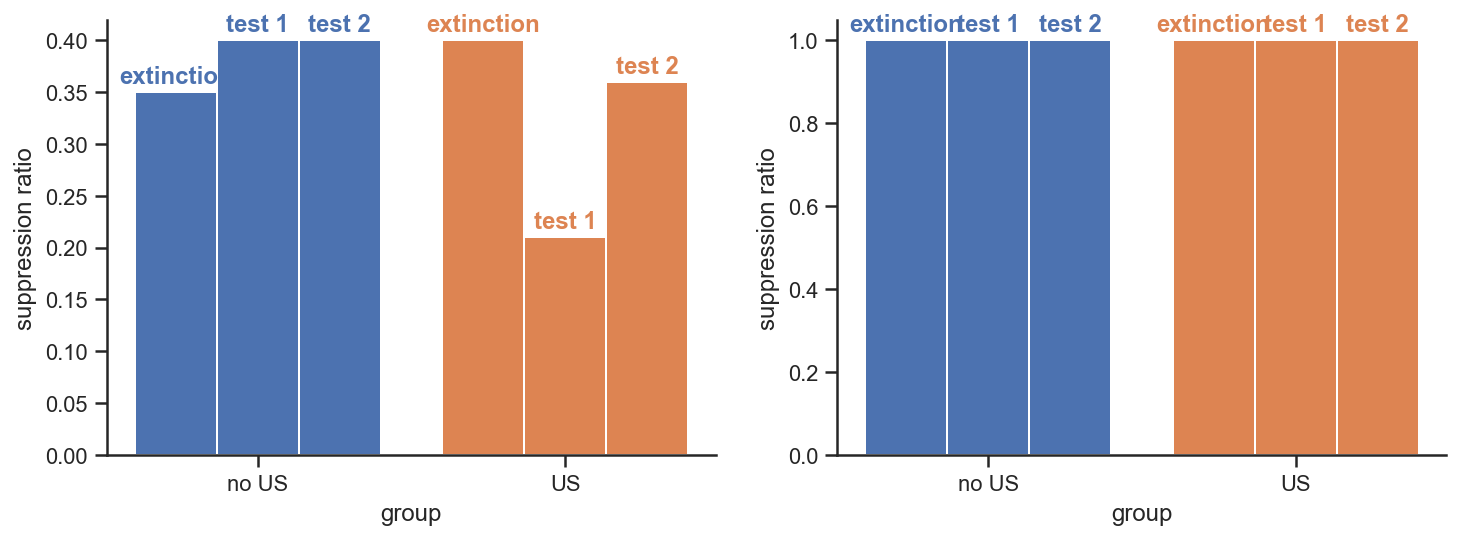

In [7]:
import ccnlab.benchmarks.classical as classical
from ccnlab.evaluation import correlation
    
for exp in classical.registry('Rec*'):
    print(exp.name)
    for g, group in exp.stimuli.items():
        for subject in range(1):
            model = RandomModel()
            for i, trial in enumerate(group):
                for t, timestep in enumerate(trial):
                    cs, ctx, us = timestep
                    res = model.act(cs, ctx, us)
                    exp.data[g][i][t]['response'].append(res)

    try:
        results = exp.results
        summary = exp.summarize()
        print('    correlation:', correlation(results, summary))
        display_side_by_side(results, summary)
        exp.plot(show='both')
        plt.show()
    except NotImplementedError:
        continue

# Extensions

In [16]:
display(pd.melt(
  pd.DataFrame(
    columns=['group', 'time', 'A', 'AB', 'ABC'],
    data=[
      ['con', 1, 80, 65, 55],
      ['con', 2, 80, 65, 55],
      ['par', 1, 20, 90, 70],
      ['par', 2, 20, 90, 70],
      ['hoo', 1, 20, 50, 85],
      ['hoo', 2, 20, 50, 85],
    ]
  ),
  id_vars=['group', 'time']
))

display(pd.melt(
  pd.DataFrame(
    columns=['group', 'time', 'A'],
    data=[
      ['con', 1, 80],
      ['con', 2, 80],
      ['par', 1, 20],
      ['par', 2, 20],
      ['hoo', 1, 33],
      ['hoo', 2, 33],
    ]
  ),
  id_vars=['group', 'time']
))

display()

,group,time,variable,value
0,con,1,A,80
1,con,2,A,80
2,par,1,A,20
3,par,2,A,20
4,hoo,1,A,20
5,hoo,2,A,20
6,con,1,AB,65
7,con,2,AB,65
8,par,1,AB,90
9,par,2,AB,90


,group,time,variable,value
0,con,1,A,80
1,con,2,A,80
2,par,1,A,20
3,par,2,A,20
4,hoo,1,A,33
5,hoo,2,A,33


In [8]:
import ccnlab.benchmarks.classical.core as cc

In [16]:
class TestExperiment(cc.ClassicalConditioningExperiment):
    def __init__(self, n=10, partial_prob=0.5):
        super().__init__({
            'control': cc.seq(cc.trial('AB+'), repeat=6),
            'special': cc.seq(cc.trial('AB+'), repeat=6),
        })
        self.results = pd.melt(pd.DataFrame(
            columns=['group', 'trial', 'AB'],
            data=[
                ['control', 1, 0.2],
                ['control', 2, 0.3],
                ['control', 3, 0.4],
                ['control', 4, 0.5],
                ['control', 5, 0.6],
                ['control', 6, 0.7],
                ['special', 1, 0.2],
                ['special', 2, 0.3],
                ['special', 3, 0.4],
                ['special', 4, 0.5],
                ['special', 5, 0.6],
                ['special', 6, 0.7],
            ]
        ), id_vars=['group', 'trial'])
        self.meta = dict(ylabel='hi')
        self.plots = [
            lambda df, ax, **info: cc.plot_lines(df, ax=ax),
            lambda df, ax, **info: cc.plot_bars(df[df['trial'] == 6], ax=ax),
        ]

    def summarize(self):
        return pd.melt(self.dataframe(lambda x: {
            'AB': cc.conditioned_response(x['trial'], x['response'], ['A', 'B']),
        }), id_vars=['group', 'trial']).groupby(['group', 'trial', 'variable']).mean().reset_index()

# Implementation

In [13]:
import ccnlab.benchmarks.classical.core as cc

## Syntax tree `self.spec`

In [14]:
# Standard cs_active=(4, 8), us_active=(7, 8)
display(cc.trial('AB+'))

# Control of time
display(cc.trial(('A', 4, 8), ('B', 4, 8), ('+', 7, 8)))

# Control of time + magnitude
display(cc.trial(('A', 4, 8, 0.5), ('B', 4, 8, 0.5), ('+', 7, 8, 0.8)))

# All syntax.
display(cc.seq(
    cc.sample({
        cc.trial('A+'): 8,
        cc.trial('A-'): 2,
    }),
    name='train',
    repeat=1,
))

Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1), Stimulus(stim='B', start=4, end=8, mag=1)), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1))

Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1), Stimulus(stim='B', start=4, end=8, mag=1)), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1))

Trial(cs=(), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=0.8))

Sequence(children=(Sample(prob={Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1),), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=1)): 8, Trial(cs=(Stimulus(stim='A', start=4, end=8, mag=1),), ctx='K1', us=Stimulus(stim='+', start=7, end=8, mag=0)): 2}),), repeat=1, name='train')

In [15]:
display(cc.build_stimuli(cc.trial('AB+')))
display(cc.build_stimuli(cc.sample({ cc.trial('A'): 1, cc.trial('B'): 1 })))
display(cc.build_stimuli(cc.seq(cc.trial('A'), cc.trial('B'), repeat=3)))
display(cc.build_stimuli(cc.seq(cc.sample({ cc.trial('A'): 1, cc.trial('B'): 1 }), repeat=4)))

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 0),
   ([('A', 1), ('B', 1)], 'K1', 1)]],
 [None])

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)]],
 [None])

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], '

([[([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0),
   ([('B', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)],
  [([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0),
   ([('A', 1)], 'K1', 0)]],
 [None, None, None, None])

## Summary statistics `summarize()`

In [18]:
stimuli, phases = cc.build_stimuli(cc.trial('AB+'))
stimuli = stimuli[0]
responses = [0, 0, 1, 0, 0, 1, 1, 1]
display(stimuli)
display(responses)
print('total:', cc.count_responses(stimuli, responses))
print('ctx only:', cc.count_responses(stimuli, responses, during_cs=[]))
print('cs period:', cc.count_responses(stimuli, responses, during_cs=['A', 'B'], during_us=False))
print('cr:', cc.conditioned_response(stimuli, responses, during_cs=['A', 'B']))
print('sr:', cc.suppression_ratio(stimuli, responses, during_cs=['A', 'B']))

[([], 'K1', 0),
 ([], 'K1', 0),
 ([], 'K1', 0),
 ([], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 0),
 ([('A', 1), ('B', 1)], 'K1', 1)]

[0, 0, 1, 0, 0, 1, 1, 1]

total: 4
ctx only: 1
cs period: 2
cr: 0.6666666666666666
sr: 0.6666666666666666


In [20]:
df = pd.melt(pd.DataFrame(
    columns=['group', 'trial', 'cr'],
    data=[
        [1, 1, 1],
        [1, 2, 2],
        [1, 3, 3],
        [1, 4, 4],
        [1, 5, 5],
        [1, 6, 6],
        [2, 1, 2],
        [2, 2, 4],
        [2, 3, 6],
        [2, 4, 8],
        [2, 5, 10],
        [2, 6, 12],
    ]
), id_vars=['group', 'trial'])

# def trials_to_sessions(
#     df,
#     trials_per_session,
#     keep_first=False,
#     trial_name='trial',
#     session_name='session',
#     value_name='value',
# )

display(df)
cc.trials_to_sessions(df, 3, keep_first=True)

,group,trial,variable,value
0,1,1,cr,1
1,1,2,cr,2
2,1,3,cr,3
3,1,4,cr,4
4,1,5,cr,5
5,1,6,cr,6
6,2,1,cr,2
7,2,2,cr,4
8,2,3,cr,6
9,2,4,cr,8


,group,session,variable,value
0,1,0,cr,1
1,1,1,cr,2
2,1,2,cr,5
3,2,0,cr,2
4,2,1,cr,4
5,2,2,cr,10


## Plotting `plot()`

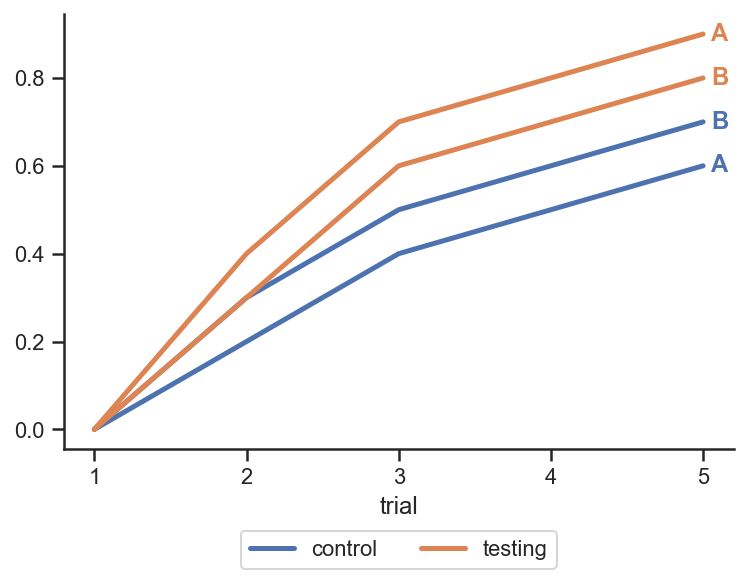

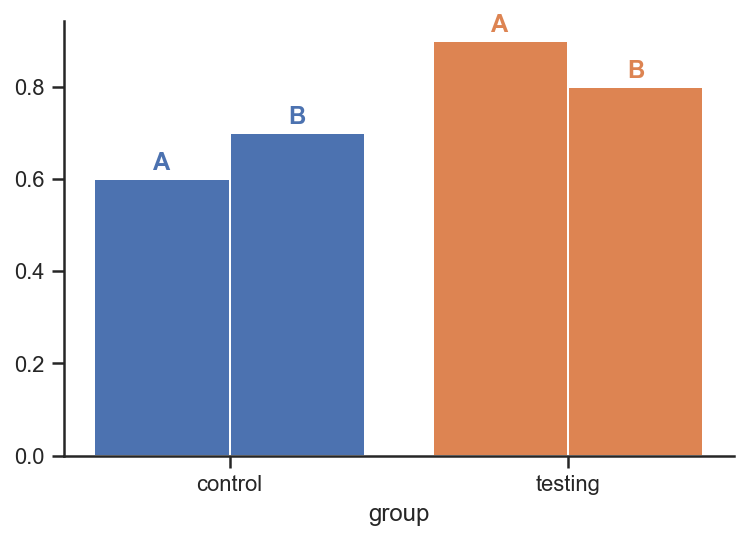

In [21]:
df = pd.melt(pd.DataFrame([
    ['control', 1, 0, 0], ['control', 2, 0.2, 0.3], ['control', 3, 0.4, 0.5], ['control', 4, 0.5, 0.6], ['control', 5, 0.6, 0.7],
    ['testing', 1, 0, 0], ['testing', 2, 0.4, 0.3], ['testing', 3, 0.7, 0.6], ['testing', 4, 0.8, 0.7], ['testing', 5, 0.9, 0.8],
], columns=['group', 'trial', 'A', 'B']), id_vars=['group', 'trial'])
cc.plot_lines(df)
cc.plot_bars(df[df['trial'] == 5])

In [23]:
df1 = pd.melt(pd.DataFrame(
    columns=['group', 'trial', 'cr', 'cr2'],
    data=[
        [1, 2, 3, 6],
        [2, 3, 4, 8],
        [3, 4, 5, 10],
    ]
), id_vars=['group', 'trial'])
df2 = pd.melt(pd.DataFrame(
    columns=['group', 'trial', 'cr', 'cr2'],
    data=[
        [1, 2, 3, 7],
        [2, 3, 5, 8],
        [3, 4, 6, 9],
    ]
), id_vars=['group', 'trial'])
display(df1, df2)

from ccnlab.evaluation import correlation
correlation(df1, df2)

,group,trial,variable,value
0,1,2,cr,3
1,2,3,cr,4
2,3,4,cr,5
3,1,2,cr2,6
4,2,3,cr2,8
5,3,4,cr2,10


,group,trial,variable,value
0,1,2,cr,3
1,2,3,cr,5
2,3,4,cr,6
3,1,2,cr2,7
4,2,3,cr2,8
5,3,4,cr2,9


0.9585966633705806

In [ ]:
# X compute cr per trial
# X compare simulated vs experimental stats

# X plotting

# X cr per trial = [group, trial, cr]; group by session?
# X cr per group = [group, cr]; select by phase? select by trial stimuli?

# saving experiments (pickle) and plots (matplotlib)

# QUESTIONS
# session vs trial?
# how to measure CR not UR? Use sum or max over timesteps in trial?
# what is suppression ratio baselines?

# QUESTIONS
# suppression ratio for only aversive stimuli?
# suppression ratio smoothing? edge case of denom 0?

# IDEA: allow for both summary stats input and full experimental data
# IDEA: configurable evaluation function

# QUESTIONS
# aggregating across sessions
# suppression ratio, vs suppression, vs normal cr

# don't implement differences, experiment-level appetitive/aversive, us-level appetitive/aversive, transform all into common framework
# averaging
